In [1]:
import gym

import random
import numpy as np

import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from time import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    BACKUP_PATH='drive/My Drive/Colab Notebooks/DQN_model.tar'
except ModuleNotFoundError:
    BACKUP_PATH='./source/DQN_model.tar'

In [2]:
BATCH_SIZE = 64

GAMMA = 0.999
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 500

TARGET_UPDATE = 10
BACKUP_INTERVAL = 2000

IS_NEW_RUN = True

env = gym.make('Breakout-v4', new_step_api=True, obs_type='ram').unwrapped

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [3]:
class ExpSmoothedArr():
    def __init__(self, beta, init_arr=None) -> None:
        self.beta = beta
        self.arr = []

        if init_arr is not None:
            for val in init_arr:
                self.append(val)

    def append(self, val) -> None:
        if len(self.arr) > 0:
            self.arr.append(self.arr[-1] * self.beta + val * (1 - self.beta))
        else:
            self.arr.append(val)

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory():

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class DQNNet(nn.Module):

    def __init__(self, inputs: int, outputs: int) -> None:
        super(DQNNet, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.BatchNorm1d(inputs),
            torch.nn.Linear(inputs, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU()
        ) 
        self.layer2 = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU()
        ) 
        self.layer3 = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU()
        ) 
        self.layer4 = torch.nn.Sequential(
            torch.nn.Linear(64, outputs)
        ) 

    
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [6]:
class DQN():

    def __init__(self, inputs: int, outputs: int) -> None:
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"using {self.device}")

        self.policy_net = DQNNet(inputs, outputs).to(self.device)

        self.target_net = DQNNet(inputs, outputs)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-2)
        self.memory = ReplayMemory(100000)

        self.current_epoch = 0
        self.scores = []
        self.episode_durations = []
        self.smooth_scores = ExpSmoothedArr(beta=0.9)
        self.smooth_episode_durations = ExpSmoothedArr(beta=0.9)
        self.steps_done = 0
        self.training_time = 0

    def backup(self, path: str) -> None:
        timer = time()
        torch.save({
                'current_epoch': self.current_epoch,
                'model_state_dict': self.policy_net.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'memory': self.memory,
                'scores': self.scores,
                'episode_durations': self.episode_durations,
                'steps_done': self.steps_done,
                'training_time': self.training_time
                }, path)
        print(f'backup done in {round(time() - timer, 1)} sec')

    def restore(self, path: str) -> None:
        timer = time()
        checkpoint = torch.load(path, map_location=self.device)
        self.policy_net.load_state_dict(checkpoint['model_state_dict'])
        self.policy_net.train()
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.memory = checkpoint['memory']

        self.current_epoch = checkpoint['current_epoch']
        self.scores = checkpoint['scores']
        self.episode_durations = checkpoint['episode_durations']
        self.steps_done = checkpoint['steps_done']
        self.training_time = checkpoint['training_time']

        self.smooth_scores = ExpSmoothedArr(beta=0.9, init_arr=self.scores)
        self.smooth_episode_durations = ExpSmoothedArr(beta=0.9, init_arr=self.episode_durations)
        print(f'Duration of model reading was {round(time() - timer, 1)} sec')

    def select_action(self, state):
        sample = random.random()
        eps_threshold = EPS_END + (EPS_START - EPS_END) * \
            (1e6 - self.steps_done) / 1e6 * (self.steps_done < 1e6 )
        # eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        #     math.exp(-1. * steps_done / EPS_DECAY)
        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) will return largest column value of each row.
                # second column on max result is index of where max element was
                # found, so we pick action with the larger expected reward.
                return self.target_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(n_actions)]], device=self.device, dtype=torch.int64)

    def optimize(self):
        if len(self.memory) < BATCH_SIZE:
            return
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=self.device,
            dtype=torch.bool
        )
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=self.device)

        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute loss
        loss = torch.nn.functional.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        self.steps_done += 1

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    def show_stat(self):
        print(f"{model.current_epoch} episodes played at all")
        print(f"{model.steps_done} learning steps done at all")
        plt.figure(figsize=(18, 6))
        plt.plot(model.scores)
        plt.plot(model.smooth_scores.arr)
        plt.show()

        plt.figure(figsize=(18, 6))
        plt.plot(model.episode_durations)
        plt.plot(model.smooth_episode_durations.arr)
        plt.show()

In [7]:
# Get number of actions from gym action space
n_actions = env.action_space.n
observation_shape = env.observation_space.shape[0]

model = DQN(inputs=observation_shape, outputs=n_actions)

if not IS_NEW_RUN:
    model.restore(BACKUP_PATH)

print('Current epoch is', model.current_epoch)
print(model.steps_done, 'steps done')
print(f'{round(model.training_time / 60, 1)} min already trained')

using cpu
Current epoch is 0
0 steps done
0.0 min already trained


In [8]:
learning_iter_number = 10000
steps_threshold = model.steps_done + learning_iter_number

timer = time()
tmp_timer = timer
print('Began at ', datetime.fromtimestamp(timer).strftime("%H:%M:%S"))
# for i_episode in range(num_episodes):
i_episode = 0
while model.steps_done < steps_threshold:
    i_episode += 1
    state = torch.tensor(np.array([env.reset()]), device=model.device, dtype=torch.float32)
    R = 0

    for t in count():
        # Select and perform an action
        action = model.select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        next_state = torch.tensor(np.array([next_state]), device=model.device, dtype=torch.float32)
        R += reward

        next_state = None if done else next_state
        reward = torch.tensor(np.array([reward]), device=model.device, dtype=torch.float32)

        # Store the transition in memory
        model.memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        model.optimize()
        
        if done:
            model.episode_durations.append(t + 1)
            model.smooth_episode_durations.append(t + 1)
            model.scores.append(R)
            model.smooth_scores.append(R)
            break

        # Update the target network, copying all weights and biases in DQN
        if (t % TARGET_UPDATE == 0) and (t > 0):
            model.update_target_net()

    model.current_epoch += 1
    if (i_episode % BACKUP_INTERVAL == 0) and (i_episode > 0):
        model.train_time += time() - tmp_timer
        tmp_timer = time()
        model.backup(BACKUP_PATH)
        clear_output(wait=True)
        print(f"{i_episode} episodes done in {round((time() - timer)/60, 1)}m")
        model.show_stat()

print('Finished at ', datetime.fromtimestamp(time()).strftime("%H:%M:%S"))
print('Duration of calculations was %.1f min' %((time() - timer)/60))

Began at  22:40:01
Finished at  22:41:02
Duration of calculations was 1.0 min


In [9]:
model.backup(BACKUP_PATH)

backup done in 1.8 sec


44 episodes played at all
10055 learning steps done at all


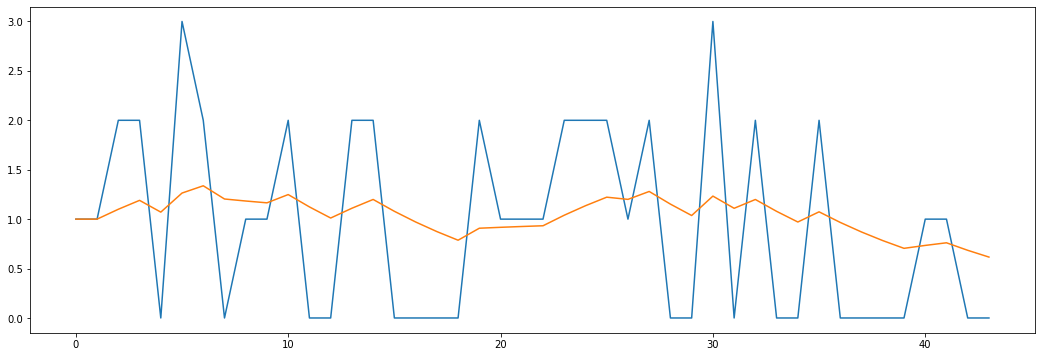

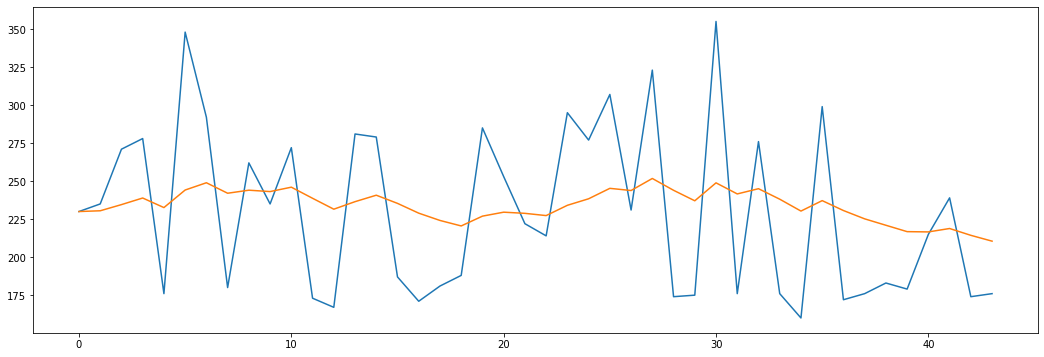

In [10]:
model.show_stat()

In [11]:
i_episode, len(model.scores), model.current_epoch, model.training_time, model.steps_done

(44, 44, 44, 0, 10055)

In [12]:
env.close()